# Autoencoder using JAX AI Stack

This notebook demonstrate how to build a simple autoencoder model using JAX AI Stack.
If you're interested in more such notebooks, please checkout [github.com/inclinedadarsh/jax-ai-notebooks](https://github.com/inclinedadarsh/jax-ai-notebooks)

**Note**: This notebook is not a part of the JAX AI Tutorial, it is solely implemented by me to practice JAX & Flax.

## Imports

In [278]:
# Imports from AI stack
import jax
import optax
import jax.numpy as jnp
from flax import nnx

# For dataset
from sklearn.datasets import load_digits
# For visualization
import matplotlib.pyplot as plt
# For splitting the dataset
from sklearn.model_selection import train_test_split

## Exploring the data

In [280]:
# Loading the dataset
digits = load_digits()
print(f"{digits.data.shape=}")
print(f"{digits.target.shape=}")

digits.data.shape=(1797, 64)
digits.target.shape=(1797,)


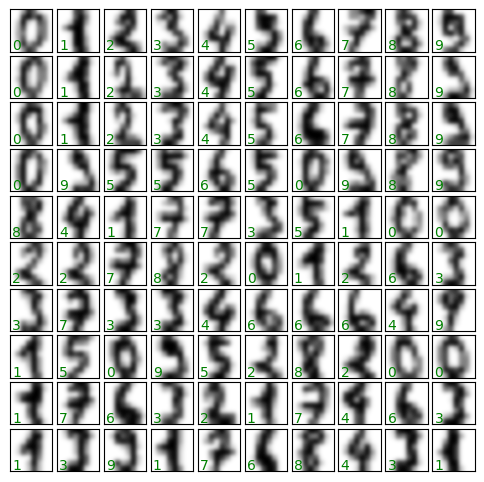

In [264]:
# Visualizing the data
fig, axes = plt.subplots(10, 10, figsize=(6, 6),
                         subplot_kw={'xticks': [], 'yticks': []},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='gaussian')
    ax.text(0.05, 0.05, str(digits.target[i]), transform=ax.transAxes, color='green')

In [265]:
splits = train_test_split(digits.images, digits.target, random_state=42)

images_train, images_test, label_train, label_test = map(jnp.asarray, splits)

In [281]:
print(f"{images_train.shape=} {label_train.shape=}")
print(f"{images_test.shape=} {label_test.shape=}")

images_train.shape=(1347, 8, 8) label_train.shape=(1347,)
images_test.shape=(450, 8, 8) label_test.shape=(450,)


## Building the model

### Model architecture

In [282]:
class AutoEncoder(nnx.Module):
    def __init__(self, rngs: nnx.Rngs):
        self.n_features = 64
        
        # ENCODER
        self.layer1 = nnx.Linear(64, 32, rngs=rngs)
        self.layer2 = nnx.Linear(32, 16, rngs=rngs)
        self.layer3 = nnx.Linear(16, 8, rngs=rngs)

        # DECODER
        self.layer4 = nnx.Linear(8, 16, rngs=rngs)
        self.layer5 = nnx.Linear(16, 32, rngs=rngs)
        self.layer6 = nnx.Linear(32, 64, rngs=rngs)

        # DROPOUT LAYER
        # self.dropout = nnx.Dropout(0.2, rngs=rngs)
        # Turns out, we don't actually need dropout

    def __call__(self, x):
        x = x.reshape(x.shape[0], self.n_features)
        
        # ENCODER
        x = nnx.selu(self.layer1(x))
        # self.dropout(x)
        x = nnx.selu(self.layer2(x))
        # self.dropout(x)
        x = nnx.selu(self.layer3(x))

        # DECODER
        x = nnx.selu(self.layer4(x))
        # self.dropout(x)
        x = nnx.selu(self.layer5(x))
        # self.dropout(x)
        x = self.layer6(x)
        return x

In [283]:
model = AutoEncoder(rngs=nnx.Rngs(0))

In [284]:
nnx.display(model)

### Other components

In [287]:
optimizer = nnx.Optimizer(model, optax.adam(learning_rate=0.005))

In [288]:
def loss_fn(
    model: nnx.Module,
    data: jax.Array,
    output_data: jax.Array
):
    output_data = output_data.reshape(output_data.shape[0], 64)
    data = model(data)
    loss = jnp.mean((data - output_data) ** 2)
    return loss

In [289]:
@nnx.jit
def train_step(
    model: nnx.Module,
    optimizer: nnx.Optimizer,
    data: jax.Array,
    labels: jax.Array
):
    def compute_loss(model: nnx.Module):
        return loss_fn(model, data, labels)

    loss, grads = nnx.value_and_grad(compute_loss)(model)
    optimizer.update(grads)
    return loss

### Let's train!

In [290]:
for i in range(2001):
    loss = train_step(model, optimizer, images_train, images_train)
    if i % 50 == 0:
        test_loss = loss_fn(model, images_test, images_test)
        print(f"epoch: {i}: loss={test_loss:.2f}")

epoch: 0: loss=53.23
epoch: 50: loss=15.27
epoch: 100: loss=11.02
epoch: 150: loss=10.29
epoch: 200: loss=9.68
epoch: 250: loss=9.24
epoch: 300: loss=8.79
epoch: 350: loss=8.29
epoch: 400: loss=7.88
epoch: 450: loss=7.57
epoch: 500: loss=7.32
epoch: 550: loss=7.13
epoch: 600: loss=6.95
epoch: 650: loss=6.62
epoch: 700: loss=6.43
epoch: 750: loss=6.26
epoch: 800: loss=6.20
epoch: 850: loss=6.01
epoch: 900: loss=5.88
epoch: 950: loss=5.73
epoch: 1000: loss=5.63
epoch: 1050: loss=5.56
epoch: 1100: loss=5.49
epoch: 1150: loss=5.43
epoch: 1200: loss=5.38
epoch: 1250: loss=5.34
epoch: 1300: loss=5.29
epoch: 1350: loss=5.23
epoch: 1400: loss=5.21
epoch: 1450: loss=5.16
epoch: 1500: loss=5.16
epoch: 1550: loss=5.15
epoch: 1600: loss=5.11
epoch: 1650: loss=5.07
epoch: 1700: loss=5.07
epoch: 1750: loss=5.04
epoch: 1800: loss=5.05
epoch: 1850: loss=5.03
epoch: 1900: loss=5.03
epoch: 1950: loss=5.00
epoch: 2000: loss=4.98


**Observation**: So with the current implementation, the minimum loss I have observed is **4.98**, which I'm sure can be reduced further. Some of the ways to reduce the error further can be:
1. Increasing the number parameters (layers)
2. Normalizing the input data
3. Train for more epochs

Also, adding regualarization didn't work, most probably because it was not needed in the first place, however adding more layers might need some regularization as well.

## Visualizing output

While it's good to see the error going down epoch by epoch, let's visualize the reconstructed output, so we can see how well our autoencoder is performing

In [291]:
def visualize_reconstructions(model, images, num_images = 5):
    reconstructed = model(images[:num_images])
    reconstructed = reconstructed.reshape(-1, 8, 8)

    plt.figure(figsize=(6, 6))
    for i in range(num_images):
        plt.subplot(2, num_images, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title('Original')
        plt.axis('off')
        plt.subplot(2, num_images, i + num_images + 1)
        plt.imshow(reconstructed[i], cmap='gray')
        plt.title('Recon')
        plt.axis('off')

    plt.show()

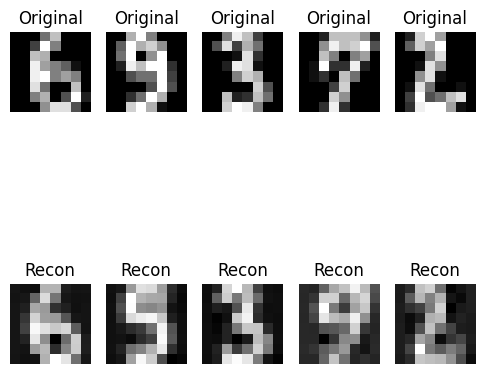

In [292]:
visualize_reconstructions(model, images_test)

It looks good, but definitely can be improved. If you want to get some intuition, you can try plotting the latent layer on a 2d graph by plotting a plane of two most important weights. While it might not be the best way to visualize, but definitely can provide some intuition.